## Logistic Regression - Titanic

The titanic dataset is a popular dummy dataset used to learn about logistic regression. It has also been used in a [Kaggle data science competition](https://www.kaggle.com/c/titanic), so you'll also find blogposts exploring all kinds of more advanced concepts that use this dataset too! In this assignment, you'll do a logistic regression to look at the effect of sex and class on survival on the titanic, by computing odds ratios.

adapted from: https://github.com/jstray/lede-algorithms/blob/master/week-3/week-3-2-homework.ipynb

Some references:

- [What are odds vs. probability?](https://towcenter.gitbooks.io/curious-journalist-s-guide-to-data/content/analysis/counting_possible_worlds.html)
- [Investigate.ai on Logistic Regressions](https://investigate.ai/regression/logistic-regression-quickstart/)
- [StatQuest Logistic Regressions Playlist](https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe)
- [How do I interpret odds ratios in logistic regression?](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) This one's a little more technical, but has good examples.


In [362]:
import pandas as pd
import numpy as np 
from plotnine import *

import warnings
warnings.filterwarnings('ignore')


### Load the data

Read in the `titanic.csv` data set again.

In [363]:
# Load titanic.csv
df = pd.read_csv('titanic.csv')
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender
0,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male
3,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male
...,...,...,...,...,...,...,...,...,...,...
1308,3rd,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male
1309,3rd,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male
1310,3rd,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male
1311,3rd,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female


The first thing we need to do is code the pclass and gender variables numerically. Let's use the following scheme:
- pclass: 1,2,3
- gender: 0=male, 1=female, and let's call the column called "female" to remind us which is which

In [91]:
# recode the pclass and gender variables so they are numeric
df['pclass'] = df.pclass.replace({'1st': 1, '2nd': 2, '3rd': 3})
df['female'] = df.gender.replace({'male': 0, 'female': 1})
df.head(3)

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0


### 1. Exploratory data analysis

First, let's do some **descriptive stats**. Our aim in this notebook is to determine what factors impact surival. So let's start by looking at a few pivot tables of `survived` versus factors like `gender` and `pclass`.

In [207]:
print("How many men and women are travelling on the titanic?")
display(pd.crosstab(df.gender, df.survived, margins=True))

print("What share of each survived? \n(probability)")
display(pd.crosstab(df.gender, df.survived, margins=True, normalize='index').round(2))


How many men and women are travelling on the titanic?


survived,0,1,All
gender,,,
female,156,307,463
male,708,142,850
All,864,449,1313


What share of each survived? 
(probability)


survived,0,1
gender,,
female,0.34,0.66
male,0.83,0.17
All,0.66,0.34


In [171]:
print("How many people are travelling in each class?")
display(pd.crosstab(df.pclass, df.survived, margins=True))
display(pd.crosstab(df.pclass, df.survived, margins=True, normalize='columns').round(2))

How many people are travelling in each class?


survived,0,1,All
pclass,,,
1,129,193,322
2,161,119,280
3,574,137,711
All,864,449,1313


survived,0,1,All
pclass,,,
1,0.15,0.43,0.25
2,0.19,0.27,0.21
3,0.66,0.31,0.54


### 2. Logistic regression with one variable at a time

First, do a logistic regression of the `female` variable alone to predict the probability of survival. Below is some code that will help you plot the result.

**Step 1: Run a logistic regression on one variable and see the summary of the output**


In [153]:
# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression
import statsmodels.formula.api as smf

model = smf.logit("survived ~ female", data=df)
results = model.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.517411
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1311
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Apr 2022   Pseudo R-squ.:                  0.1945
Time:                        02:18:18   Log-Likelihood:                -679.36
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                 2.572e-73
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6066      0.092    -17.473      0.000      -1.787      -1.426
female         2.2836      0.135     16.963      0.000       2.020       2.547
==============================================================================
"""

Okay...so our Pseudo R-squared is about .2, and the p-vlaues are significant. Looks like gender does provide us some information about whether or not someone will survive. Let's make some predictions using this very simple model.

**Step 2: analyze the dataframe with predicted values**


In [155]:
# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions
df['prediction'] = results.predict()
df.head()

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.663067
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.167059
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.663067
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.167059


Hmm...interesting. There are only two possible outcomes for the prediction (which in the case of logistic regression is the chance that someone will survive). 

In [160]:
df.prediction.unique().round(2)

array([0.66, 0.17])

That makes sense though. The only thing this model considers is whether or not someone is female. On that basis it can only make two possible predictions.

Also, don't those numbers look familiar? .66 and .17 are the values from the pivot table ‼️ BAM!

In this simple one-variable case, the logistic regression predictions are simply the probabilities of survival for men and women.

**Step 3: What is the odds ratio of on the gender variable alone?**

In [214]:
# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})

coefs.round(2)


,coef,odds ratio,pvalue,name
Intercept,-1.61,0.20,0.0,Intercept
female,2.28,9.81,0.0,female


The `coef` is the log of the odds ratio. We exponentiate that to get the odds ratio of 9.8

So in this simple model, the odds of survival are 9.8 times higher for women than men.



In [215]:
print("What share of each survived? \n(probability)")
display(pd.crosstab(df.gender, df.survived, margins=True, normalize='index').round(2).iloc[: ,1:])

print("What share of each survived? \n(odds)")
display(
    pd.crosstab(df.gender, df.survived).iloc[: ,1] / pd.crosstab(df.gender, df.survived).iloc[: ,0]
)

What share of each survived? 
(probability)


survived,1
gender,
female,0.66
male,0.17
All,0.34


What share of each survived? 
(odds)


gender
female    1.967949
male      0.200565
dtype: float64

WHOA! the odds of survival are 1.97 for women and .2 for men

And the odds ratio is 🥁🥁🥁🥁🥁🥁 1.97/.2 = 9.81

Same as the Logistic Regression!!! 

So in this simple one variable case...the logistic regression isn't doing much more than simple probability calculations!

**Now, try the same thing but with the `pclass` variable**

In [88]:
# Step 1: Run a logistic regression on one variable and see the summary of the output

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

In [ ]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

In [ ]:
# Step 3: What is the odds ratio of on the pclass variable alone?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds


**Bonus** 🤖 - Writing clean/DRY code

DRY stands for "Don't Repeat Yourself". This is a good principle of writing clean code. Instead of copy/pasting code multiple times (which can lead to errors if you fix one copy but not the other), you can write DRY code by wrapping any chunk of code you plan to repeat in a function. As a bonus on this section, re-write the code above as a function and run that function once on `female` and once on `pclass`.

### 3. Looking at two variables at a time

We know from the earlier assignment that class also affects survival, so let's add that to our model. Compute a logistic regression on the variables `pclass` and `female`.

In [222]:
# Logistic regression on two variables

# hint: 
# https://investigate.ai/regression/logistic-regression-quickstart/#Performing-a-regression

import statsmodels.formula.api as smf

model = smf.logit("survived ~ pclass + female", data=df)
results = model.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.457739
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1313
Model:                          Logit   Df Residuals:                     1310
Method:                           MLE   Df Model:                            2
Date:                Tue, 12 Apr 2022   Pseudo R-squ.:                  0.2874
Time:                        02:44:03   Log-Likelihood:                -601.01
converged:                       True   LL-Null:                       -843.38
Covariance Type:            nonrobust   LLR p-value:                5.504e-106
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6210      0.196      3.173      0.002       0.237       1.005
pclass        -1.0373      0.088    -11.787      0.000      -1.210      -0.865
female         2.4285      0.151     16.117      0.000       2.133       2.724
==============================================================================
"""

Both variables have a significant p-value, the pseudo R-squared is better...meaning we have a better representation of the odds of survival with this model! Looks like considering both age and class of a person together give us a better representation of whether or not they will survive.

In [229]:
# Step 2: analyze the dataframe with predicted values

# hint: 
# you'll need to create a new column on df and use results.predict() to assign it values
# https://investigate.ai/regression/logistic-regression-quickstart/#Making-predictions

df = df.assign(prediction=results.predict())
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.882065
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.882065
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.397390
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.882065
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.397390
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.076494
1309,3,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.076494
1310,3,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male,0,0.076494
1311,3,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female,1,0.484385


Now there are several predicted values...six to be exact! 

3 classes x 2 genders = 6 possible predictions

In [231]:
df.prediction.unique()

array([0.88206507, 0.39739034, 0.18943946, 0.72608056, 0.07649418,
       0.48438533])

In [232]:
# Step 3: What is the odds ratio of on the gender variable?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})

coefs.round(2)

,coef,odds ratio,pvalue,name
Intercept,0.62,1.86,0.0,Intercept
pclass,-1.04,0.35,0.0,pclass
female,2.43,11.34,0.0,female


Now our odds ratio is 11.34 on `female` and `.35` on pclass. The coefficients allow you to compare `pclass` to `female` and the odds ratios allow you to more meaningfully interpret the increase or decrease in odds of survival based on gender or pclass.

### 4. What does this mean

What is the odds ratio on the `pclass` variable? What happens to the odds of survival when we move from 1st to 2nd or from 2nd to 3rd class?


👉 The odds ratio on `female` was 9.8 for the model `survived ~ female`

👉 The odds ratio on `female` was 11.34 for the model `survived ~ pclass + female` (which does a better job at explaining the variance in who survived or not because it has a higher Pseudo R-squared)

This means that when we **control for** the effect of class, the gender disparity chances of surival increases. Women are more likely to surive than we had originally thought.

But are ticket class and gender the only things that determine your chance of survival?

### 5. Bonus - Age

Does the age of a passenger impact their chances of survival?

What about age? Were older people more likely to survive than younger people


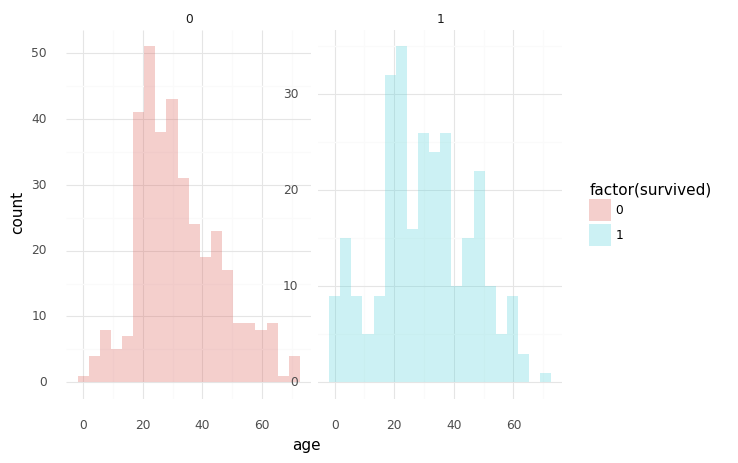

<ggplot: (332904030)>

In [308]:
# Since age is a continous variable..the pivot tables we used above aren't too helpful anymore
print("What about age? Were older people more likely to survive than younger people")
display(
    ggplot(df.query('age.notna()'), aes(x='age', fill='factor(survived)'))
     + geom_histogram(alpha=.3, bins=20)
     + facet_wrap('survived', scales='free_y')
     + theme_minimal()
)


Hmm...the histograms look quite similar...**EXCEPT** what is that bump on the left side among survivors? Looks a bigger share of a the survivors are children than the non-survivors.

Let's explore this phenomenon in the context of the other variables (in our Logistic Regression!)

In [288]:
import statsmodels.formula.api as smf

model = smf.logit("survived ~ pclass + female + age", data=df)
results = model.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.426398
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      629
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Apr 2022   Pseudo R-squ.:                  0.3792
Time:                        03:11:01   Log-Likelihood:                -269.91
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                 3.662e-71
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8188      0.502      5.620      0.000       1.836       3.802
pclass        -1.4224      0.170     -8.387      0.000      -1.755      -1.090
female         3.0862      0.241     12.790      0.000       2.613       3.559
age           -0.0489      0.009     -5.673      0.000      -0.066      -0.032
==============================================================================
"""

In [285]:
df = df.query('age.notna()') # note that we're dropping about half the dataframe here!!!!!
df = df.assign(prediction=results.predict())
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,0.944085
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.996347
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0,0.412158
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1,0.951699
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male,0,0.963522
...,...,...,...,...,...,...,...,...,...,...,...,...
833,3,0,"Gronnestad, Mr Daniel Danielsen",32.0000,Southampton,"Foresvik, Norway Portland, ND",NaN,NaN,NaN,male,0,0.040683
835,3,0,"Gustafsson, Mr Alfred Ossian",20.0000,Southampton,"Waukegan, Chicago, IL",NaN,NaN,NaN,male,0,0.064679
836,3,0,"Gustafsson, Mr Anders Vilhelm",37.0000,Southampton,"Ruotsinphytaa, Finland New York, NY",NaN,NaN,NaN,male,0,0.035180
837,3,0,"Gustafsson, Mr Johan Birger",28.0000,Southampton,"Ruotsinphytaa, Finland New York, NY",NaN,NaN,NaN,male,0,0.046464


Since age is a continous variable, we have LOTS of predictions now.

In [289]:

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})

coefs.round(2)

,coef,odds ratio,pvalue,name
Intercept,2.82,16.76,0.0,Intercept
pclass,-1.42,0.24,0.0,pclass
female,3.09,21.89,0.0,female
age,-0.05,0.95,0.0,age


Holy Moly! The odds ratio for `female` shot way up in this new model. And we know this new model is better than the old one. Remember the Pseudo R-squared for this model `survived ~ pclass + female + age` is almost double what we had for `survived ~ female`.


So once we **control for** the class of a passenger's ticket and their age, a female passenger has more than 20 times the odds of survival of male passenger!

#### Extra - transforming age for a better model




In [287]:
# Here I take np.log(age). Why? Because a 1-year-old and a 10-year-old are quite different, 
# whereas a 55-year-old and a 65-year-old are not so different...but inputting age as a 
# linear variable doesn't reflect this...a natural log, however, helps to account for that!
#
# another way to do this might have been to bucket the ages into "child", "teenager", "adult", "elderly"
# or something along those lines
#
# This is a TRANSFORMATION of the input to better reflect the truth we're modeling
# later on, in machine learning land, we'll call this "Feature Engineering"
#
# finally...the age doesn't NEED to be transformed, but this does improve the model a little and allow us 
# to better predict probability of survival

import statsmodels.formula.api as smf

model = smf.logit("survived ~ pclass + female + np.log(age)", data=df)
results = model.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.417000
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      629
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Apr 2022   Pseudo R-squ.:                  0.3929
Time:                        03:10:49   Log-Likelihood:                -263.96
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                 9.719e-74
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.5525      0.735      6.193      0.000       3.112       5.993
pclass         -1.3691      0.164     -8.350      0.000      -1.690      -1.048
female          3.1462      0.245     12.828      0.000       2.665       3.627
np.log(age)    -1.0404      0.171     -6.097      0.000      -1.375      -0.706
===============================================================================
"""

## MISC ... some other charts I made

Rolling average of 20 people at a time...their average age vs chance of survival for each class

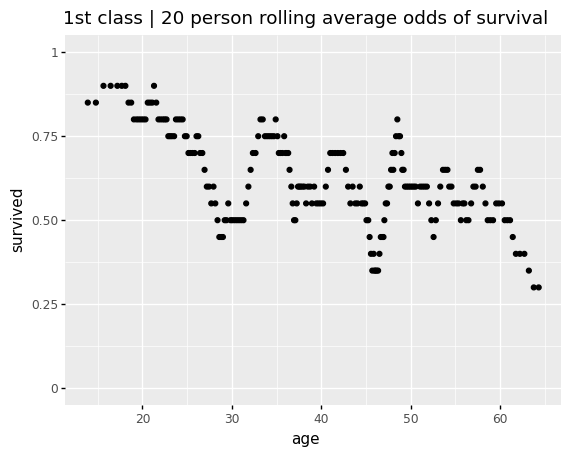

<ggplot: (332629875)>

In [304]:
(
ggplot(df[['age', 'survived','pclass']].query('pclass==1').dropna().sort_values(by='age').rolling(20, center=False).mean().dropna()) +
    geom_point(aes(x='age', y='survived')) +
    ylim(0,1) +
    ggtitle("1st class | 20 person rolling average odds of survival")
)

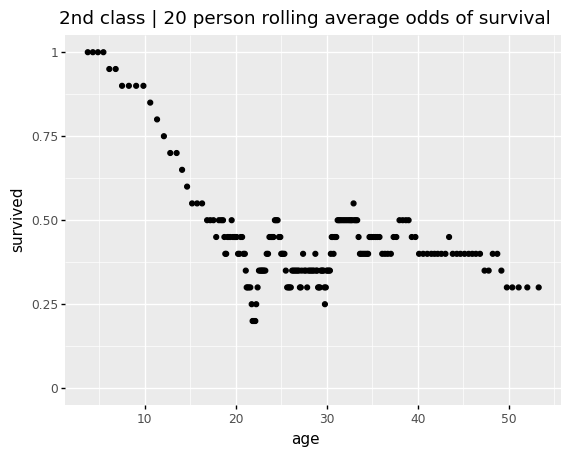

<ggplot: (332247456)>

In [305]:
(
ggplot(df[['age', 'survived','pclass']].query('pclass==2').dropna().sort_values(by='age').rolling(20, center=False).mean().dropna()) +
    geom_point(aes(x='age', y='survived')) +
    ylim(0,1) +
    ggtitle("2nd class | 20 person rolling average odds of survival")
)

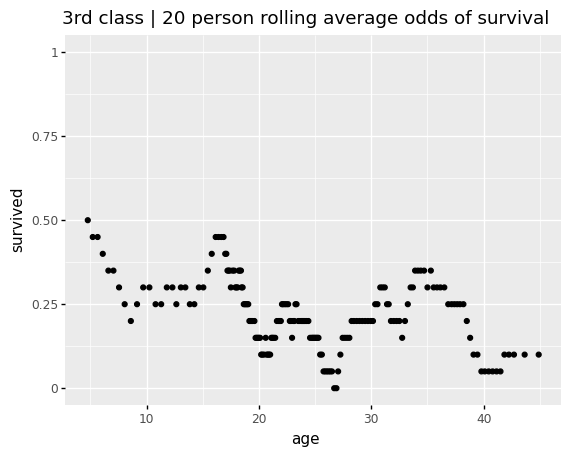

<ggplot: (332647226)>

In [306]:
(
ggplot(df[['age', 'survived','pclass']].query('pclass==3').dropna().sort_values(by='age').rolling(20, center=False).mean().dropna()) +
    geom_point(aes(x='age', y='survived')) +
    ylim(0,1) +
    ggtitle("3rd class | 20 person rolling average odds of survival")
)

# What if I look at age as a binary?

In [336]:

import statsmodels.formula.api as smf

model = smf.logit("survived ~ pclass + female + age<16", data=df)
results = model.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.430884
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      629
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Apr 2022   Pseudo R-squ.:                  0.3727
Time:                        03:30:02   Log-Likelihood:                -272.75
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                 6.210e-70
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5432      0.272      1.995      0.046       0.010       1.077
age < 16[T.True]     1.9827      0.376      5.273      0.000       1.246       2.720
pclass              -1.1394      0.148     -7.674      0.000      -1.430      -0.848
female               3.0906      0.241     12.845      0.000       2.619       3.562
====================================================================================
"""

In [337]:

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})

coefs.round(2)

,coef,odds ratio,pvalue,name
Intercept,0.54,1.72,0.05,Intercept
age < 16[T.True],1.98,7.26,0.00,age < 16[T.True]
pclass,-1.14,0.32,0.00,pclass
female,3.09,21.99,0.00,female


This gives us a more explainable result.

# The story

- Sometimes you spend hours crafting the right sentence from the model
- Many times the model informs the story. For example, here are some headlines that could come of an analysis like this:
    - **Women and Children First** // Not everyone escaped on a lifeboat that tragic day
    - **The Rich Were Safer** // Passengers aboard the titanic who could afford to pay were more likely to be saved

Most of the time, the model isn't the story. It simply helps you to tell the story.

So we can ask ourselves if, in this case, talking about odds ratios or effect sizes makes the story more powerful, or needlessly distracts from the point? Can we go back to our simple pivot tables as we report out what exactly happened that day the titanic hit an iceberg?

In [385]:
def categorize_age(age):
    if np.isnan(age):
        return 'unknown'
    
    if age<18:
        return 'child'
    else: 
        return 'adult'



df = pd.read_csv('titanic.csv')\
    .assign(
        child = lambda x: x.age.apply(categorize_age)
    )

df.pivot_table(
    columns='survived', index=['pclass', 'gender', 'child'], aggfunc='count', values='name', margins=True
).fillna(0).astype('int')

survived                 0    1   All
pclass gender child                  
1st    female adult      4   90    94
              child      1    6     7
              unknown    4   38    42
       male   adult     82   37   119
              child      0    6     6
              unknown   38   16    54
2nd    female adult     10   61    71
              child      0   14    14
              unknown    3   19    22
       male   adult    104   10   114
              child      2   11    13
              unknown   42    4    46
3rd    female adult     20   18    38
              child      9   10    19
              unknown  105   51   156
       male   adult    103   12   115
              child     17    6    23
              unknown  320   40   360
All                    864  449  1313